1. Rewrite Notebook
2. Rewrite code to fit notebook
3. Get all plots according to notebook
4. Comment and transform code
5. Push notebook

In [2]:
import numpy as np
from math import *
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import copy
import matplotlib.animation as animation

# Set 1

## 1.1 Vibrating string

#### A. Discriteze the wave equation and write it in a form suitable for implementing in a computer program.


#### B. Implement the time stepping. Determine the time development of the string, with the following initial conditions. The string is at rest at t = 0, i.e. Ψ′(x,t = 0) = 0. Take c = 1 and use the time step ∆t = 0.001. Plot the result at several times in the same figure, e.g. varying the color of the curve.

#### C. Make an animated plot of the time development.

## 1.2 The Time Dependent Diffusion Equation

#### D. Determine the equation to use at the boundaries of the domain. Clearly show the ranges of the indices of the grid. A figure is extremely helpful for figuring this out.

We use assume periodic boundary conditions at x = 0 and x = 1. For x = 1, the scheme would then be:

   
   
$c^{k+1}_{i,j}$ = $c^K_{N,j} + \frac{\delta t D}{\delta x^2}$ $(c^k_{0, j} + c^k_{N-1,j} + c^k_{N,j-1} - 4c^k_{N,j})$

In [154]:
class diffusion_equation():
    
    def __init__(self, times=[0.001,0.01, .1]):
        
        # initalizing values over grid
        self.Nx, self.Ny = 50, 50
        self.dx, self.dy = 1/self.Nx, 1/self.Ny
        self.D = 1
        
        # time values
        self.dt = 0.00001
        self.times = times
        self.time = self.times[-1]
        
        
        # initial values
        self.c = np.zeros((self.Ny,self.Nx))
        self.c[0] = 1
        self.cs = []
        self.timesteps = np.arange(0, self.time+self.dt, self.dt)
        
        
    def time_dependent_formula(self, j, i):
        # apply time dependent formula
        self.c[j][i] = self.c[j][i] + (self.dt*self.D/self.dx**2)*(self.c[j][(i+1)%self.Nx] + 
                self.c[j][(i-1)%self.Nx] + self.c[j+1][i] + self.c[j-1][i] - 4*self.c[j][i])
        return self.c
    
    def analytical_formula(self, count):
        analytical_solution = []
        for y in np.arange(0.,1.0,.001):
            # set i and Dt
            i = (self.Ny-1)
            Dt = self.times[count]
            # apply analytical formula
            y_sol = np.sum([erfc((1-y+2*i)/(2*sqrt(Dt))) - 
                                      erfc((1+y+2*i)/(2*sqrt(Dt))) for i in range(self.Ny)])
            # add result to a list
            analytical_solution.append(y_sol)
        # return analytical solutions
        return analytical_solution
    
    def time_dependent_iteration(self, square=False, rectangle=False):
        with tqdm(total=self.time/self.dt) as pbar:
            # time-stepping
            for timestep in self.timesteps:
                # all vertical lines
                for j in range(1,self.Ny-1):
                    # all horizontal lines
                    for i in range(self.Nx):
                        if square == True:
                            if ((j,i) not in [(x,y) for x in range(20,30) for y in range(20,30)]):
                                self.time_dependent_formula(j, i)
                        elif rectangle == True:
                            if ((j,i) not in [(x,y) for x in range(10,30) for y in range(20,30)]):
                                self.time_dependent_formula(j, i)
                        else:
                            self.time_dependent_formula(j, i)
                # add timesteps to plot
                if timestep in self.times:
                    self.cs.append(copy.copy(self.c))
                pbar.update()
    
    def time_independent_iteration(self, iteration_type, N, D, error, w=1, square=False):
        
        
        maxdelta = 1
        k = 0
        
        if iteration_type == 'Jacobi': 
            
            c_prev = np.zeros((N,N))
            c_prev[0] = 1
            self.c = copy.deepcopy(c_prev)
            
            while maxdelta > error:
                k += 1
                maxdelta = 0
                for j in range(1,N-1):
                    for i in range(N):
                        if square == True:
                            if ((j,i) not in [(x,y) for x in range(20,30) for y in range(20,30)]):
                                self.c[j][i] = (1/4)*(c_prev[j][(i+1)%N] + 
                                        c_prev[j][(i-1)%N] + c_prev[j+1][i] + c_prev[j-1][i])
                                delta = fabs(self.c[j][i]-c_prev[j][i])
                                if delta > maxdelta:
                                    maxdelta = delta
                        else:
                            self.c[j][i] = (1/4)*(c_prev[j][(i+1)%N] + 
                                    c_prev[j][(i-1)%N] + c_prev[j+1][i] + c_prev[j-1][i])
                            delta = fabs(self.c[j][i]-c_prev[j][i])
                            if delta > maxdelta:
                                maxdelta = delta
                c_prev = copy.deepcopy(self.c)
            return self.c, k
        
        if iteration_type == 'SOR':

            self.c = np.zeros((N,N))
            self.c[0] = 1

            while maxdelta > error:
                k += 1
                maxdelta = 0
                for j in range(1,N-1):
                    for i in range(N):
                        if square == True:
                            if ((j,i) not in [(x,y) for x in range(20,30) for y in range(20,30)]):
                                prev = self.c[j][i]
                                self.c[j][i] = (w/4)*(self.c[j][(i+1)%N] + 
                                        self.c[j][(i-1)%N] + self.c[j+1][i] + self.c[j-1][i]) + (1-w)*self.c[j][i]
                                delta = fabs(self.c[j][i]-prev)
                                if delta > maxdelta:
                                    maxdelta = delta
                        else:
                            prev = self.c[j][i]
                            self.c[j][i] = (w/4)*(self.c[j][(i+1)%N] + 
                                    self.c[j][(i-1)%N] + self.c[j+1][i] + self.c[j-1][i]) + (1-w)*self.c[j][i]
                            delta = fabs(self.c[j][i]-prev)
                            if delta > maxdelta:
                                maxdelta = delta
            return self.c, k
    

        
    
    def plot_results(self, showComparison=False, showProgress=False, makeVid=False, iteration=True):
        
        if iteration == True: 
            print('hello')
            
        if showComparison == True:
            count = 0
            for c in self.cs:
                # plot the simulation result line
                line1, = plt.plot(np.arange(0.,1,1/self.Ny),list(reversed(c[:,int(self.Ny/2)])), 'k',label='simulation')
                # calculate and plot the analytical result line
                analytical_solution = self.analytical_formula(count)
                line2, = plt.plot(np.arange(0.,1,0.001),analytical_solution, 'k--',label='analytical solution')
                count += 1

            # set title and labels
            plt.title('Simulation vs. Analytical solutions of the time dependent diffusion equation')
            plt.legend(handles=[line1,line2], loc='best')
            plt.ylabel("c")
            plt.show()  
        
        if showProgress == True:
            count = 0
            # show progress of diffusion visually
            for c in self.cs:
                plt.imshow(c, cmap='bone')
                plt.title('Visualization of the diffusion at time ' + str(self.times[count]))
                plt.show()
                count += 1
                
        if makeVid == True:
            fig = plt.figure()

            ims = []
            count = 0
            for c in self.cs:
                im = plt.imshow(c, cmap='bone')
                
                ims.append([im])
                count += 1

            ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True)
            ani.save('dynamic_images.html')


In [30]:
model = diffusion_equation()
model.time_dependent_iteration()

100001it [11:47, 141.28it/s]                                      


#### E. Test the correctness of your simulation. Compare to the analytic solutions, plot c(y) for different times. 

hello


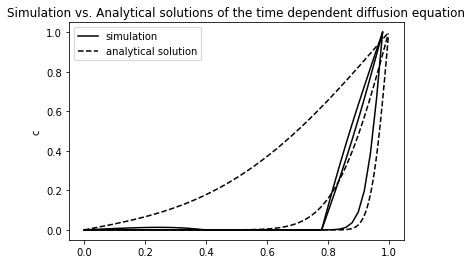

In [101]:
model.plot_results(showComparison=True)

#### F. Plot the results, show the 2D domain, with a color representing the concentration at each point. Make a plot of the state of the system at several times: t = {0, 0.001, 0.01, 0.1, and 1}.

hello


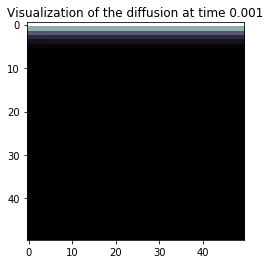

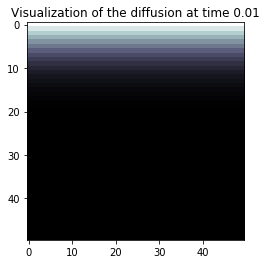

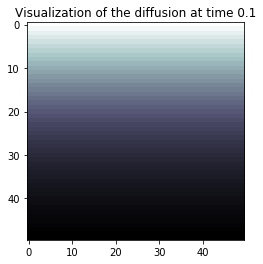

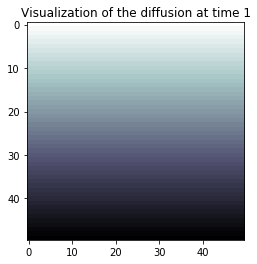

In [31]:
model.plot_results(showProgress=True)

#### G. Make an animated plot of the time dependent diffusion equation until equilibrium.

In [8]:
times = np.arange(0, 1, .01)

model = diffusion_equation(times)
model.time_dependent_iteration()

model.plot_results(makeVid=True)

  6%|▌         | 5848/98999.99999999999 [00:44<11:43, 132.50it/s]


KeyboardInterrupt: 

# question for TA: animated plot of the visualization or the graph? 

## 1.3 The Time Independent Diffusion Equation

## 1.4 The Jacobi Iteration

## 1.5 The Gauss-Seidel Iteration

## 1.6 Successive Over Relaxation

####  H. Implement the Jacobi iteration, the Gauss-Seidel method and SOR. Try N = 50. Test the methods by comparing the result to the analytical result in eq. (5), i.e. the linear dependence of the concentration on y.

[array(1.), array(0.88878029), array(0.77757368), array(0.66639169), array(0.55524287), array(0.44413175), array(0.33305836), array(0.22201813), array(0.11100252), array(0.)]
9


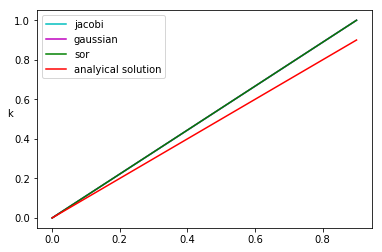

100%|██████████| 6/6 [00:01<00:00,  3.04it/s]


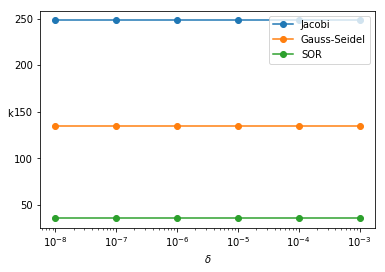

In [160]:

jacobi, gaussian, sor = [], [], []
error = 1e-5
N = 50

jacobi.append(model.time_independent_iteration("Jacobi", N, 1, error, 1)[0])
gaussian.append(model.time_independent_iteration("SOR", N, 1, error, 1)[0])
sor.append(model.time_independent_iteration("SOR", N, 1, error, 1.7)[0])


jacobi = np.array(jacobi)
gaussian = np.array(gaussian)
sor = np.array(sor)
jacobi_results = []
gaussian_results = []
sor_results = []

for i in range(0, N):
    top_level = np.array(list(reversed(jacobi[:,i]))[0][int(N/2)])
    jacobi_results.append(top_level)
    top_level = np.array(list(reversed(gaussian[:,i]))[0][int(N/2)])
    gaussian_results.append(top_level)
    top_level = np.array(list(reversed(sor[:,i]))[0][int(N/2)])
    sor_results.append(top_level)
    
analytical_solution = np.arange(0, 1, (1/N))

plt.plot(np.arange(0, 1, (1/N)),list(reversed(jacobi_results)), 'k',label='jacobi', color='c')
plt.plot(np.arange(0, 1, (1/N)),list(reversed(gaussian_results)), 'k',label='gaussian', color='m')
plt.plot(np.arange(0, 1, (1/N)),list(reversed(sor_results)), 'k',label='sor', color='g')
plt.plot(np.arange(0, 1, (1/N)),analytical_solution, 'k',label='analyical solution', color='r')

plt.ylabel('k').set_rotation(0)
plt.legend(loc='best')
plt.show()

j = np.array(j)

j, g, s = [], [], []
errors = [1e-3,1e-4,1e-5,1e-6,1e-7,1e-8]

with tqdm(total=len(errors)) as pbar:
    for err in errors:
        j.append(model.time_independent_iteration("Jacobi", N, 1, error, 1)[1])
        g.append(model.time_independent_iteration("SOR", N, 1, error, 1)[1])
        s.append(model.time_independent_iteration("SOR", N, 1, error, 1.7)[1])
        pbar.update()

plt.semilogx(errors, j, marker='o', label='Jacobi')
plt.semilogx(errors, g, marker='o', label='Gauss-Seidel')
plt.semilogx(errors, s, marker='o', label='SOR')
plt.xlabel(r'$\delta$')
plt.ylabel('k').set_rotation(0)
plt.legend(loc='best')
plt.show()


In [84]:
x = ([56,1],[35,1],[24,1],[43,2],[23,2],[65,2])
print(x[:,0])
x = np.array(([56,1],[35,1],[24,1],[43,2],[23,2],[65,2]))

TypeError: tuple indices must be integers or slices, not tuple

#### J. In the SOR method, find the optimal ω. How does it depend on N?.

 53%|█████▎    | 16/30 [03:49<02:36, 11.18s/it]


KeyboardInterrupt: 

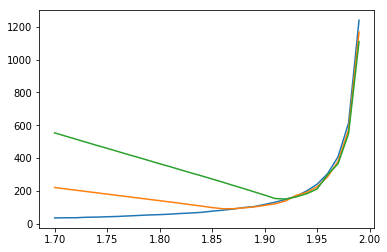

In [20]:
model = diffusion_equation()

# optimal w:

N_range = [10, 30, 50, 75, 100]
ws = np.arange(1.7,1.99,0.01)

for N in N_range:
    # plot optimal omega:
    ks = []
    with tqdm(total=ws.size) as pbar:
        for w in ws:
            ks.append(model.time_independent_iteration("SOR", N, 1, 1e-5, w)[1])
            pbar.update()
    title = 'N = ' + str(N)
    plt.plot(ws,ks, label=title)

plt.xlabel(r'$\omega$')
plt.ylabel('k').set_rotation(0)
plt.legend(loc='best')
plt.show()
    

#### G. Implement the possibility to include objects into the computational domain. The objects should be sinks. 
    - Experiment a little bit with some objects in the computational domain (e.g. a rectangle or a few rectangles, ...). 

10001it [15:22, 29.06it/s]                               


hello


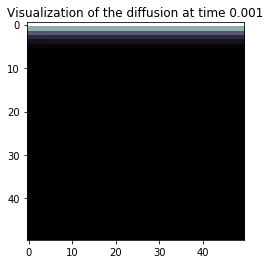

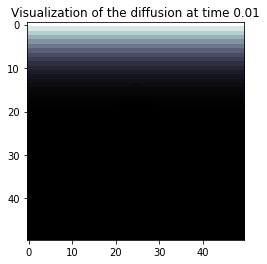

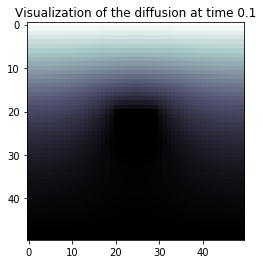

10001it [1:27:02, 16.55it/s]                                 


hello


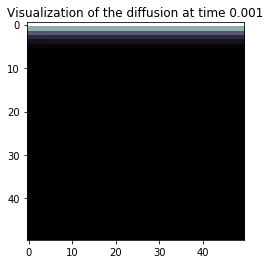

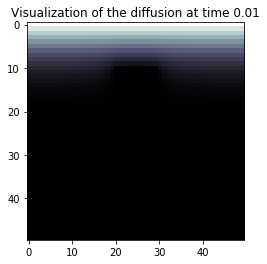

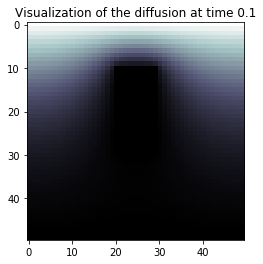

In [37]:
# show different examples

model = diffusion_equation()
model.time_dependent_iteration(square=True)
model.plot_results(showProgress=True)

model = diffusion_equation()
model.time_dependent_iteration(rectangle=True)
model.plot_results(showProgress=True)

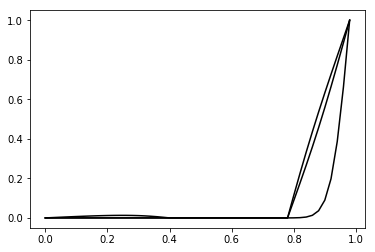

In [85]:
for c in model.cs:
    plt.plot(np.arange(0.,1,1/50),list(reversed(c[:,int(50/2)])), 'k',label='simulation')

    - What is the influence on the number of iterations?

In [ ]:
# influence on the number of iterations

model = diffusion_equation()

SOR_square, SOR = [], []
errors = [1e-3,1e-4,1e-5,1e-6,1e-7,1e-8]

with tqdm(total=len(errors)) as pbar:
    for err in errors:
        # with square
        SOR_square.append(model.time_independent_iteration("SOR", 25, 1, err, 1.7, square=True)[1])
        # without square
        SOR.append(model.time_independent_iteration("SOR", 25, 1, err, 1.7, square=False)[1])
        pbar.update()
        
        
plt.semilogx(errors, SOR_square, marker='o', label='SOR with square')
plt.semilogx(errors, SOR, marker='o', label='SOR')
plt.xlabel(r'$\delta$')
plt.ylabel('k').set_rotation(0)
plt.legend(loc='best')
plt.show()

    - What about the optimal ω , is it influenced by the presence of objects? Look at the resulting concentration fields, and try to interpret what happens. 

In [ ]:
# plot optimal omega:
omega = np.arange(1.7,1.99,0.01)
iterations, iterations_square = []
with tqdm(total=ws.size) as pbar:
    for omega in omegas:
        # without square
        iterations.append(model.time_independent_iteration("SOR", 25, 1, 1e-5, omega)[1])
        # with square
        iterations_square.append(model.time_independent_iteration("SOR", 25, 1, 1e-5, omega, square=True)[1])
        pbar.update()
plt.plot(omegas,iterations_square, label='Optimal mega with square')
plt.plot(omegas,iterations, label='Optimal mega without square')
plt.xlabel(r'$\omega$')
plt.ylabel('k').set_rotation(0)
plt.show()

#### H. Optional. Think of a way to incorporate objects with insulating material in your domain. What changes in the time evolution of the system? And in the final state?